In [1]:
# document --> https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_agentic_rag/#2-create-a-retriever-tool
# %%capture --no-stderr
# %pip install -U --quiet langgraph "langchain[openai]" langchain-community langchain-text-splitters


In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ['GROQ_API_KEY']=os.getenv("GROQ_API_KEY")

## Online web postloading


In [2]:
# from langchain_community.document_loaders import WebBaseLoader

# urls = [
#     "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
#     "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
#     "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
# ]

# docs = [WebBaseLoader(url).load() for url in urls]

In [3]:
# docs[0][0].page_content.strip()[:1000]

In [ ]:
# from langchain_text_splitters import RecursiveCharacterTextSplitter

# docs_list = [item for sublist in docs for item in sublist]

# text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
#     chunk_size=100, chunk_overlap=50
# )
# doc_splits = text_splitter.split_documents(docs_list)

In [ ]:
# doc_splits[2].page_content.strip()

## custom pdf loading

In [4]:
# from langchain_community.document_loaders import PyPDFLoader

# pdf_path = "./vtune-profiler_user-guide_2023.1-766319-773628.pdf"

# # Load the PDF into LangChain Documents
# loader = PyPDFLoader(pdf_path)
# docs = loader.load()  # List of Document objects

In [7]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

pdf_path = "./vtune-profiler_user-guide_2023.1-766319-773628.pdf"

# Load PDF pages as documents
loader = PyPDFLoader(pdf_path)
documents = loader.load()  # List of Document objects, each representing a page

# Now you can pass this directly to the splitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=100
)

# Split documents into smaller chunks
doc_splits = text_splitter.split_documents(documents)

# doc_splits is now a list of smaller Document chunks ready for further use

In [9]:
doc_splits[2].page_content.strip()

'Build and Install the Sampling Drivers for Linux* Targets ............. 92\nDebug Information for Linux* Application Binaries....................... 96\nCompiler Switches for Performance Analysis on Linux* Targets...... 97\nEnable Linux* Kernel Analysis................................................. 101\nResolution of Symbol Names for Linux-Loadable Kernel Modules.. 103\nAnalyze Statically Linked Binaries on Linux* Targets .................. 104\nSet Up Remote Linux* Target ................................................. 105\nEmbedded Linux* Targets............................................................... 115\nConfigure Yocto Project* and VTune Profiler with the Integration\nLayer .............................................................................. 120\nConfigure Yocto Project*/Wind River* Linux* and Intel® VTune™\nProfiler with the Intel System Studio Integration Layer........... 122\nConfigure Yocto Project* and Intel® VTune™ Profiler with the\nLinux* Target Pack

In [10]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

# Create the embedding model wrapper
embedding_model = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')

# Build the vector store
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits,
    embedding=embedding_model
)

# Create the retriever
retriever = vectorstore.as_retriever()



/tmp/ipykernel_822010/2517079203.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')


In [29]:
from langchain_core.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    # "Search and return information about Lilian Weng blog post.",
    "Serach and return information about Vtune profiler.",
)


In [30]:
retriever_tool.invoke({"query": "what is microarchitecture analysis?"})


'NOTE\nIntel® VTune™ Profiler is a new renamed version of the Intel® VTune™ Amplifier.\nHow It Works\nThe Microarchitecture Exploration analysis strategy varies by microarchitecture. For modern\nmicroarchitectures starting with Intel microarchitecture code name Ivy Bridge, the Microarchitecture\nExploration analysis is based on the Top-Down Microarchitecture Analysis Method using the Top-Down\nCharacterization methodology, which is a hierarchical organization of event-based metrics that identifies the\ndominant performance bottlenecks in an application.\nSuperscalar processors can be conceptually divided into the front-end, where instructions are fetched and\ndecoded into the operations that constitute them, and the back-end, where the required computation is\nperformed. Each cycle, the front-end generates up to four of these operations. It places them into pipeline\nslots that then move through the back-end. Thus, for a given execution duration in clock cycles, it is easy to\ndetermin

## Generate query

In [31]:
from langgraph.graph import MessagesState
from langchain_groq import ChatGroq

response_model = ChatGroq(
    model="openai/gpt-oss-20b",
    temperature=0,
    max_tokens=None,
    # reasoning_format="parsed", # not a thinking model
    timeout=None,
    max_retries=2,
    # other params...
)


def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

In [32]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I help you today?


In [33]:
input = {
    "messages": [
        {
            "role": "user",
            # "content": "What does Lilian Weng say about types of reward hacking?",
            "content":"what is microarchitecture analysis?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

### Microarchitecture Analysis – A Quick Overview

**Microarchitecture analysis** is the systematic study of the internal structure and behavior of a processor (or any digital system) at the level of its *micro‑architecture*—the concrete implementation of the instruction set architecture (ISA). It goes beyond the abstract ISA to look at how the hardware is actually built: pipelines, caches, branch predictors, execution units, interconnects, power‑management units, and more.

---

## 1. Why Do We Do It?

| Goal | Why it matters |
|------|----------------|
| **Performance tuning** | Identify bottlenecks (e.g., cache misses, pipeline stalls) and guide optimizations. |
| **Power & thermal optimization** | Pinpoint high‑power units, idle states, and leakage paths. |
| **Design validation** | Verify that a new micro‑architecture meets performance, power, and area targets. |
| **Security analysis** | Detect side

## Grade documents

In [34]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


# grader_model = init_chat_model("openai:gpt-4.1", temperature=0)  not using openai
grader_model =ChatGroq(
    model="openai/gpt-oss-20b",
    temperature=0,
    max_tokens=None,
    # reasoning_format="parsed", # not a thinking model
    timeout=None,
    max_retries=2,
    # other params...
)


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

In [35]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

In [36]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

'generate_answer'

## Rewrite question

In [37]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [45]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                # "content": "What does Lilian Weng say about types of reward hacking?",
                "content": "what is microarchitecture analysis?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1]["content"])

Could you explain what microarchitecture analysis is, how it’s performed in CPU design, and why it’s important for evaluating processor performance?


## Generate an answer

In [46]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [48]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                # "content": "What does Lilian Weng say about types of reward hacking?",
                "content": "what is microarchitecture analysis?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                # "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "content":"the Microarchitecture Exploration analysis (formerly known as General Exploration) is complete, the\nVTune Profiler opens the Microarchitecture Exploration viewpoint.",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Microarchitecture analysis is a performance profiling technique that examines how a program interacts with the underlying hardware microarchitecture—such as pipelines, caches, branch predictors, and execution units. In Intel VTune Profiler, the Microarchitecture Exploration viewpoint provides detailed metrics and visualizations of these hardware events. It helps developers identify bottlenecks at the instruction‑level and optimize code for specific CPU features.


## Assemble the graph

In [49]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

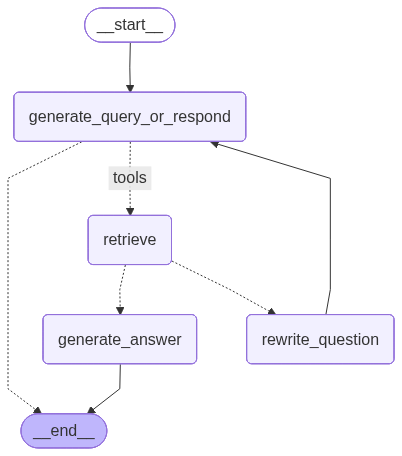

In [50]:
graph

In [52]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                # "content": "What does Lilian Weng say about types of reward hacking?",
                "content": "What is vtune?",

            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================

**VTune** (short for **Intel VTune Amplifier**) is a commercial performance‑analysis tool from Intel that helps developers find, diagnose, and fix performance bottlenecks in software. It works on a wide range of platforms (Windows, Linux, macOS) and supports many programming languages (C/C++, Fortran, Java, .NET, Python, etc.).

### What VTune does

| Feature | What it gives you |
|---------|-------------------|
| **CPU profiling** | Measures instruction counts, cache misses, branch mispredictions, CPU cycles, and other hardware counters. |
| **Hot‑spot analysis** | Identifies the functions, loops, or lines of code that consume the most CPU time. |
| **Threading & concurrency** | Detects thread contention, false sharing, lock contention, and parallel scalability issues. |
| **Memory analysis** | Shows memory bandwidth, allocation patterns, cache usage, and memory